In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import natsort
import glob
from skimage.transform import resize
import os  # You were missing this import
import pandas as pd


dataset_version = "V0"
base_dir = f"/mnt/disk/dataset/sentinel-ai-processor/{dataset_version}"
input_dir = os.path.join(base_dir, "input")
output_dir = os.path.join(base_dir, "output")

df_input = pd.read_csv(f"{base_dir}/sample_input_l1c.csv")
df_output = pd.read_csv(f"{base_dir}/sample_output_l2a.csv")

# Update the paths to be absolute
df_input["l1c_path"] = df_input["Name"].apply(lambda x: os.path.join(input_dir, os.path.basename(x).replace(".SAFE","")))
df_output["l2a_path"] = df_output["Name"].apply(lambda x: os.path.join(output_dir, os.path.basename(x).replace(".SAFE","")))

random_idx = random.randint(0, len(df_input) - 1)
random_l1c_path = df_input["l1c_path"].iloc[random_idx]
random_l2a_path = df_output["l2a_path"].iloc[random_idx]

print(f"Random index: {random_idx}")
print(f"Random l1c_path: {random_l1c_path}")
print(f"Random l2a_path: {random_l2a_path}")

image_inputs = natsort.natsorted(glob.glob(os.path.join(random_l1c_path, "*.jp2"), recursive=False))
image_outputs = natsort.natsorted(glob.glob(os.path.join(random_l2a_path, "*.jp2"), recursive=False))

Random index: 832
Random l1c_path: /mnt/disk/dataset/sentinel-ai-processor/V0/input/S2B_MSIL1C_20241201T102319_N0511_R065_T32TNT_20241201T121511
Random l2a_path: /mnt/disk/dataset/sentinel-ai-processor/V0/output/S2B_MSIL2A_20241201T102319_N0511_R065_T32TNT_20241201T125242


Resized input array shape: (3, 1080, 1080)
Resized output array shape: (3, 1080, 1080)


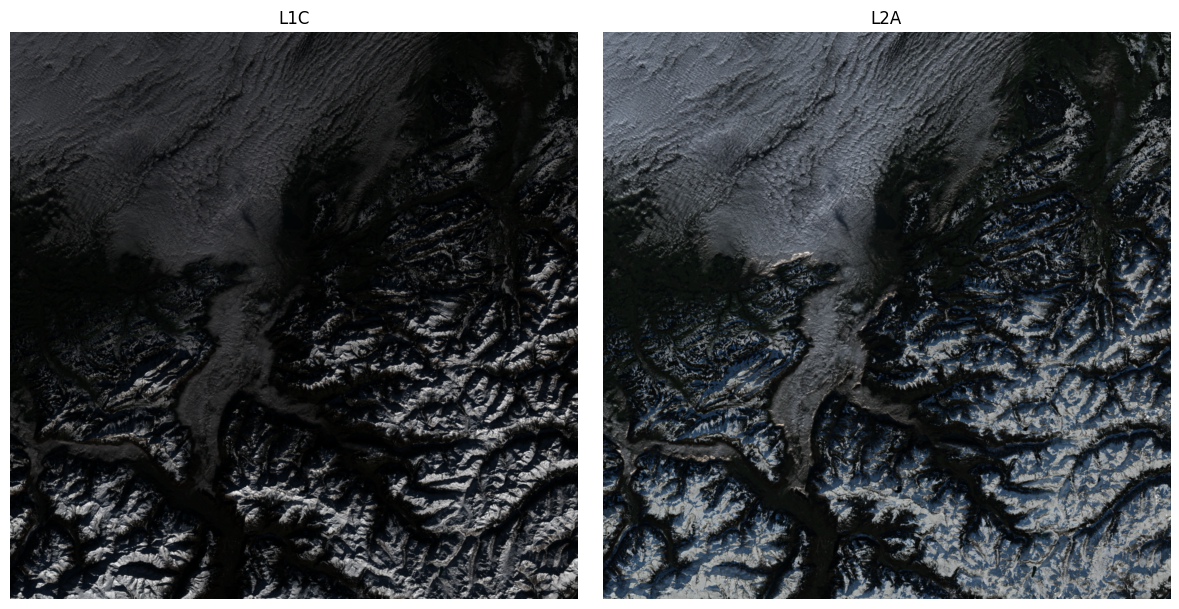

In [2]:
def normalize(band):
    """Simple min-max normalization"""
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)

def read_images_resized(image_paths, target_size=(1080, 1080)):
    """Read images and resize them to target_size"""
    bands = []
    
    for path in image_paths:
        with rasterio.open(path) as src:
            # Read the data
            data = src.read(1)
            
            # Resize to target size
            resized = resize(data, target_size, preserve_range=True)
            
            # Normalize
            normalized = normalize(resized)
            bands.append(normalized)
    
    return np.array(bands)

# Read and resize images
input_array = read_images_resized(image_inputs)
output_array = read_images_resized(image_outputs)

print(f"Resized input array shape: {input_array.shape}")
print(f"Resized output array shape: {output_array.shape}")
input_array = np.dstack((input_array[2], input_array[1], input_array[0]))
output_array = np.dstack((output_array[2], output_array[1], output_array[0]))
# Display the RGB composites
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_array)
axes[0].set_title("L1C")
axes[0].axis('off')

axes[1].imshow(output_array)
axes[1].set_title("L2A")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
import folium
import json
import numpy as np

# Create a map
m = folium.Map(zoom_start=10)

# List to store all centers
all_centers = []

# For each GeoFootprint in the dataframe
for i, geo_footprint in enumerate(df_input['GeoFootprint']):
    try:
        # Parse the GeoFootprint data
        if isinstance(geo_footprint, str):
            geo_dict = json.loads(geo_footprint.replace("'", '"'))
        else:
            geo_dict = geo_footprint
        
        # Get the coordinate list
        coordinates = geo_dict.get('geometry', {}).get('coordinates', []) or geo_dict['coordinates']
        coordinates = coordinates[0]  # First polygon
        
        # Calculate center point
        lons, lats = zip(*coordinates)
        center_lat = (min(lats) + max(lats)) / 2
        center_lon = (min(lons) + max(lons)) / 2
        
        # Store and add center point
        all_centers.append((center_lat, center_lon))
        
        # Add a simple blue dot
        folium.CircleMarker(
            location=[center_lat, center_lon],
            radius=3,
            color='blue',
            fill=True,
            fill_opacity=0.5,
            tooltip=f"Item {i}"
        ).add_to(m)
        
    except Exception as e:
        print(f"Error with item {i}: {e}")

# Center the map if we have points
if all_centers:
    m.location = [np.mean([c[0] for c in all_centers]), 
                 np.mean([c[1] for c in all_centers])]
    
    # If more than one point, fit bounds
    if len(all_centers) > 1:
        sw = [min([c[0] for c in all_centers]), min([c[1] for c in all_centers])]
        ne = [max([c[0] for c in all_centers]), max([c[1] for c in all_centers])]
        m.fit_bounds([sw, ne])

m
